In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Sat Jun 18 02:14:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install SentencePiece #restart runtime after running this cell first time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 8.8 MB/s 


In [ ]:
!pip install transformers==2.9.0
!pip install pytorch_lightning==0.7.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 635 kB 8.2 MB/s 
     |████████████████████████████████| 5.6 MB 63.7 MB/s 
     |████████████████████████████████| 880 kB 55.9 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=cbb0afd2b5a322154f0ddde38ff61f16f2291c3c8aa85c31ac2bbccd21caf9b8
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 233 kB 7.8 MB/s 
     |████████████████████████████████| 829 kB 64.0 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=6338993090b35128b9eff174a1a309d12f3dc91e7ba7475adda6650d7981afc6
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b3

In [ ]:
pip list #sentencepiece should show up as part of this!

Package                       Version
----------------------------- ------------------------------
absl-py                       1.1.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.2.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.4.0
audioread                     2.1.9
autograd                      1.4
Babel                         2.10.2
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        5.0.0
blis                          0.7.7
bokeh                         2.3.3
branca                        0.5.0
bs4                           0.0.1
CacheControl                  0.

## T5 fine-tuning

This notebook is to showcase how to fine-tune [T5 model](https://arxiv.org/abs/1910.10683) with Huggigface's [Transformers](https://github.com/huggingface/transformers/) to solve different NLP tasks using text-2-text approach proposed in the T5 paper.  
Reference: https://github.com/patil-suraj/exploring-T5 



In [ ]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl


from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
INFO:transformers.file_utils:PyTorch version 1.11.0+cu113 available.
INFO:transformers.file_utils:TensorFlow version 2.8.2 available.


In [ ]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(42)

## Model


In [ ]:
class T5FineTuner(pl.LightningModule):
  def __init__(self, hparams):
    super(T5FineTuner, self).__init__()
    self.hparams = hparams
    
    self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
    self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
  
  def is_logger(self):
    return self.trainer.proc_rank <= 0
  
  def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
  ):
    return self.model(
        input_ids,
        attention_mask=attention_mask,
        decoder_input_ids=decoder_input_ids,
        decoder_attention_mask=decoder_attention_mask,
        lm_labels=lm_labels,
    )

  def _step(self, batch):
    lm_labels = batch["target_ids"]
    lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

    outputs = self(
        input_ids=batch["source_ids"],
        attention_mask=batch["source_mask"],
        lm_labels=lm_labels,
        decoder_attention_mask=batch['target_mask']
    )

    loss = outputs[0]

    return loss

  def training_step(self, batch, batch_idx):
    loss = self._step(batch)

    tensorboard_logs = {"train_loss": loss}
    return {"loss": loss, "log": tensorboard_logs}
  
  def training_epoch_end(self, outputs):
    avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
    tensorboard_logs = {"avg_train_loss": avg_train_loss}
    return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def validation_step(self, batch, batch_idx):
    loss = self._step(batch)
    return {"val_loss": loss}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
    tensorboard_logs = {"val_loss": avg_loss}
    return {"avg_val_loss": avg_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def configure_optimizers(self):
    "Prepare optimizer and schedule (linear warmup and decay)"

    model = self.model
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": self.hparams.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
    self.opt = optimizer
    return [optimizer]
  
  def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None):
    if self.trainer.use_tpu:
      xm.optimizer_step(optimizer)
    else:
      optimizer.step()
    optimizer.zero_grad()
    self.lr_scheduler.step()
  
  def get_tqdm_dict(self):
    tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

    return tqdm_dict

  def train_dataloader(self):
    train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", args=self.hparams)
    dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
    t_total = (
        (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
        // self.hparams.gradient_accumulation_steps
        * float(self.hparams.num_train_epochs)
    )
    scheduler = get_linear_schedule_with_warmup(
        self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
    )
    self.lr_scheduler = scheduler
    return dataloader

  def val_dataloader(self):
    val_dataset = get_dataset(tokenizer=self.tokenizer, type_path="val", args=self.hparams)
    return DataLoader(val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

In [ ]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
  def on_validation_end(self, trainer, pl_module):
    logger.info("***** Validation results *****")
    if pl_module.is_logger():
      metrics = trainer.callback_metrics
      # Log results
      for key in sorted(metrics):
        if key not in ["log", "progress_bar"]:
          logger.info("{} = {}\n".format(key, str(metrics[key])))

  def on_test_end(self, trainer, pl_module):
    logger.info("***** Test results *****")

    if pl_module.is_logger():
      metrics = trainer.callback_metrics

      # Log and save results to file
      output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
      with open(output_test_results_file, "w") as writer:
        for key in sorted(metrics):
          if key not in ["log", "progress_bar"]:
            logger.info("{} = {}\n".format(key, str(metrics[key])))
            writer.write("{} = {}\n".format(key, str(metrics[key])))

In [ ]:
args_dict = dict(
    data_dir="", # path for data files
    output_dir="", # path to save the checkpoints
    model_name_or_path='t5-base',
    tokenizer_name_or_path='t5-base',
    max_seq_length=512,
    learning_rate=3e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=8,
    eval_batch_size=8,
    num_train_epochs=2,
    gradient_accumulation_steps=16,
    n_gpu=1,
    early_stop_callback=False,
    fp_16=False, # if you want to enable 16-bit training then install apex and set this to true
    opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=1.0, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=42,
)

## Emotion classification

While most of the sentiment-analysis datasets are binary with 'postive' and 'negative' sentiments, [Elvis Saravia](https://twitter.com/omarsar0)  has put together a great [dataset](https://github.com/dair-ai/emotion_dataset) for emotion recognition. The task is given some text classifiy the text into one of the following six emotions 

'sadness', 'joy', 'anger', 'fear', 'surprise', 'love'.


### Download and view data

In [ ]:
!wget https://www.dropbox.com/s/ikkqxfdbdec3fuj/test.txt
!wget https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt
!wget https://www.dropbox.com/s/2mzialpsgf9k5l3/val.txt

--2022-06-18 02:15:53--  https://www.dropbox.com/s/ikkqxfdbdec3fuj/test.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ikkqxfdbdec3fuj/test.txt [following]
--2022-06-18 02:15:53--  https://www.dropbox.com/s/raw/ikkqxfdbdec3fuj/test.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc669f89888724aecde681a6b4f1.dl.dropboxusercontent.com/cd/0/inline/BnYTrfGVRGVkRzKfSIRXa8PLFvFP7BUOdV5tuhCM-Ak5MkHI0W5XrRa-_xSB8OlWv0ut1-ZZI6xwJkRlVVXeuV4Ymbg1XPFFWqBV00BP2EnBxZQKSOT85sBGKu2UjyL2aCZrSZU3SFrHjKSdo2CNv1Rbv9UNLaGpgMJFE13S1Uo2jA/file# [following]
--2022-06-18 02:15:54--  https://uc669f89888724aecde681a6b4f1.dl.dropboxusercontent.com/cd/0/inline/BnYTrfGVRGVkRzKfSIRXa8PLFvFP7BUOdV5tuhCM-Ak5MkHI0W5XrRa-_xSB8OlWv0ut1-ZZI6xwJkRl

In [ ]:
!mkdir emotion_data
!mv *.txt emotion_data

In [ ]:
train_path = "emotion_data/train.txt"
test_path = "emotion_data/test.txt"
val_path = "emotion_data/val.txt"

## emotion labels
label2int = {
  "sadness": 0,
  "joy": 1,
  "love": 2,
  "anger": 3,
  "fear": 4,
  "surprise": 5
}

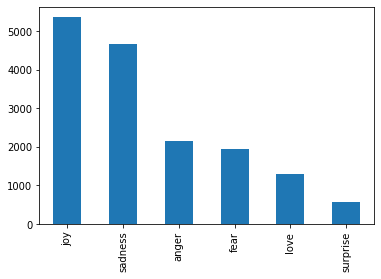

In [ ]:
data = pd.read_csv(train_path, sep=";", header=None, names=['text', 'emotion'],
                               engine="python")
data.emotion.value_counts().plot.bar()

In [ ]:
data.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
data.count()

text       16000
emotion    16000
dtype: int64

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')

INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmphc6g9tkq


Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model in cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model from cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f


### Dataset

In [ ]:
emotions = [ "sadness", "joy", "love", "anger", "fear", "surprise"]
for em in emotions:
  print(len(tokenizer.encode(em)))

1
1
1
1
1
1


In [ ]:
class EmotionDataset(Dataset):
  def __init__(self, tokenizer, data_dir, type_path,  max_len=512, data_override=[]):
    self.path = os.path.join(data_dir, type_path + '.txt')

    self.data_column = "text"
    self.class_column = "emotion"
    if (len(data_override) == 0):
      self.data = pd.read_csv(self.path, sep=";", header=None, names=[self.data_column, self.class_column],
                            engine="python")
      print(self.data)
    else:
      with open("temp.csv","w") as f:
        lines = data_override
        # print(lines)
        for line in lines:
          f.write(line+";test\n")
      with open("temp.csv","r") as f:
        self.data = pd.read_csv("temp.csv", sep=";", header=None, names=[self.data_column, self.class_column],
                            engine="python")
        print(self.data)
    
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.inputs = []
    self.targets = []

    self._build()
  
  def __len__(self):
    return len(self.inputs)
  
  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
    target_ids = self.targets[index]["input_ids"].squeeze()

    src_mask    = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
    target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze

    return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}
  
  def _build(self):
    for idx in range(len(self.data)):
      input_, target = self.data.loc[idx, self.data_column], self.data.loc[idx, self.class_column]      
      
      input_ = input_ + ' </s>'
      target = target + " </s>"

       # tokenize inputs
      tokenized_inputs = self.tokenizer.batch_encode_plus(
          [input_], max_length=self.max_len, pad_to_max_length=True, return_tensors="pt"
      )
       # tokenize targets
      tokenized_targets = self.tokenizer.batch_encode_plus(
          [target], max_length=2, pad_to_max_length=True, return_tensors="pt"
      )

      self.inputs.append(tokenized_inputs)
      self.targets.append(tokenized_targets)

In [ ]:
dataset = EmotionDataset(tokenizer, 'emotion_data', 'val', 512)
len(dataset)

                                                   text  emotion
0     im feeling quite sad and sorry for myself but ...  sadness
1     i feel like i am still looking at a blank canv...  sadness
2                        i feel like a faithful servant     love
3                     i am just feeling cranky and blue    anger
4     i can have for a treat or if i am feeling festive      joy
...                                                 ...      ...
1995  im having ssa examination tomorrow in the morn...  sadness
1996  i constantly worry about their fight against n...      joy
1997  i feel its important to share this info for th...      joy
1998  i truly feel that if you are passionate enough...      joy
1999  i feel like i just wanna buy any cute make up ...      joy

[2000 rows x 2 columns]


2000

In [ ]:
data = dataset[42]
print(tokenizer.decode(data['source_ids']))
print(tokenizer.decode(data['target_ids']))

i honestly don't feel discouraged today as i usually do
sadness


### Train

In [ ]:
!mkdir -p t5_emotion

In [ ]:
args_dict.update({'data_dir': 'emotion_data', 'output_dir': 't5_emotion', 'num_train_epochs':5}) #Here we update t5 to 5 epochs
args = argparse.Namespace(**args_dict)
print(args_dict)

{'data_dir': 'emotion_data', 'output_dir': 't5_emotion', 'model_name_or_path': 't5-base', 'tokenizer_name_or_path': 't5-base', 'max_seq_length': 512, 'learning_rate': 0.0003, 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'warmup_steps': 0, 'train_batch_size': 8, 'eval_batch_size': 8, 'num_train_epochs': 5, 'gradient_accumulation_steps': 16, 'n_gpu': 1, 'early_stop_callback': False, 'fp_16': False, 'opt_level': 'O1', 'max_grad_norm': 1.0, 'seed': 42}


In [ ]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=args.output_dir, prefix="checkpoint", monitor="val_loss", mode="min", save_top_k=5
)

train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    callbacks=[LoggingCallback()],
)

In [ ]:
def get_dataset(tokenizer, type_path, args):
  return EmotionDataset(tokenizer=tokenizer, data_dir=args.data_dir, type_path=type_path,  max_len=args.max_seq_length)

In [ ]:
# print(args)
model = T5FineTuner(args)

INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmp9wvu_lah


Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json in cache at /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165e90d374281741fc78b872cd6c9b
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165e90d374281741fc78b872cd6c9b
INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json from cache at /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165e90d374281741fc78b872cd6c9b
INFO:transformers.configuration_utils:Model config T5Config {
  "architectures": [
    "T5WithLMHeadModel"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id"

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

INFO:transformers.file_utils:storing https://cdn.huggingface.co/t5-base-pytorch_model.bin in cache at /root/.cache/torch/transformers/f6f2fde9fa7611f4eff74620de9cbe734e7a717b5b143bd283cae4c2d6022990.54f906ff53bd09195cfc183a29cadc81b7705f07fcdb796d24163cb632b6bdfa
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/f6f2fde9fa7611f4eff74620de9cbe734e7a717b5b143bd283cae4c2d6022990.54f906ff53bd09195cfc183a29cadc81b7705f07fcdb796d24163cb632b6bdfa
INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/t5-base-pytorch_model.bin from cache at /root/.cache/torch/transformers/f6f2fde9fa7611f4eff74620de9cbe734e7a717b5b143bd283cae4c2d6022990.54f906ff53bd09195cfc183a29cadc81b7705f07fcdb796d24163cb632b6bdfa
INFO:transformers.modeling_utils:Weights of T5ForConditionalGeneration not initialized from pretrained model: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight']
INFO:transformers.tokenization_utils:loading

In [ ]:
trainer = pl.Trainer(**train_params)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


In [ ]:
trainer.fit(model)

INFO:lightning:
    | Name                                                                  | Type                       | Params
-----------------------------------------------------------------------------------------------------------------
0   | model                                                                 | T5ForConditionalGeneration | 222 M 
1   | model.shared                                                          | Embedding                  | 24 M  
2   | model.encoder                                                         | T5Stack                    | 109 M 
3   | model.encoder.block                                                   | ModuleList                 | 84 M  
4   | model.encoder.block.0                                                 | T5Block                    | 7 M   
5   | model.encoder.block.0.layer                                           | ModuleList                 | 7 M   
6   | model.encoder.block.0.layer.0                                     

                                                   text  emotion
0     im feeling quite sad and sorry for myself but ...  sadness
1     i feel like i am still looking at a blank canv...  sadness
2                        i feel like a faithful servant     love
3                     i am just feeling cranky and blue    anger
4     i can have for a treat or if i am feeling festive      joy
...                                                 ...      ...
1995  im having ssa examination tomorrow in the morn...  sadness
1996  i constantly worry about their fight against n...      joy
1997  i feel its important to share this info for th...      joy
1998  i truly feel that if you are passionate enough...      joy
1999  i feel like i just wanna buy any cute make up ...      joy

[2000 rows x 2 columns]


Validation sanity check: 0it [00:00, ?it/s]

                                                    text  emotion
0                                i didnt feel humiliated  sadness
1      i can go from feeling so hopeless to so damned...  sadness
2       im grabbing a minute to post i feel greedy wrong    anger
3      i am ever feeling nostalgic about the fireplac...     love
4                                   i am feeling grouchy    anger
...                                                  ...      ...
15995  i just had a very brief time in the beanbag an...  sadness
15996  i am now turning and i feel pathetic that i am...  sadness
15997                     i feel strong and good overall      joy
15998  i feel like this was such a rude comment and i...    anger
15999  i know a lot but i feel so stupid because i ca...  sadness

[16000 rows x 2 columns]
                                                   text  emotion
0     im feeling quite sad and sorry for myself but ...  sadness
1     i feel like i am still looking at a blank canv

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1055.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_val_loss = tensor(0.0806, device='cuda:0')

INFO:__main__:loss = tensor(0.0224, device='cuda:0')

INFO:__main__:train_loss = tensor(0.0224, device='cuda:0')

INFO:__main__:val_loss = tensor(0.0806, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.5311, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.0677, device='cuda:0')

INFO:__main__:epoch = 0

INFO:__main__:loss = tensor(0.0155, device='cuda:0')

INFO:__main__:train_loss = tensor(0.0155, device='cuda:0')

INFO:__main__:val_loss = tensor(0.0677, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.0861, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.0623, device='cuda:0')

INFO:__main__:epoch = 1

INFO:__main__:loss = tensor(0.1328, device='cuda:0')

INFO:__main__:train_loss = tensor(0.1328, device='cuda:0')

INFO:__main__:val_loss = tensor(0.0623, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.0617, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.0650, device='cuda:0')

INFO:__main__:epoch = 2

INFO:__main__:loss = tensor(0.0304, device='cuda:0')

INFO:__main__:train_loss = tensor(0.0304, device='cuda:0')

INFO:__main__:val_loss = tensor(0.0650, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.0512, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.0623, device='cuda:0')

INFO:__main__:epoch = 3

INFO:__main__:loss = tensor(0.2336, device='cuda:0')

INFO:__main__:train_loss = tensor(0.2336, device='cuda:0')

INFO:__main__:val_loss = tensor(0.0623, device='cuda:0')



1

### Eval

In [ ]:
import textwrap
from tqdm.auto import tqdm
from sklearn import metrics

In [ ]:
dataset = EmotionDataset(tokenizer, 'emotion_data', 'test', 512)
print (dataset)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

                                                   text  emotion
0     im feeling rather rotten so im not very ambiti...  sadness
1             im updating my blog because i feel shitty  sadness
2     i never make her separate from me because i do...  sadness
3     i left with my bouquet of red and yellow tulip...      joy
4       i was feeling a little vain when i did this one  sadness
...                                                 ...      ...
1995  i just keep feeling like someone is being unki...    anger
1996  im feeling a little cranky negative after this...    anger
1997  i feel that i am useful to my people and that ...      joy
1998  im feeling more comfortable with derby i feel ...      joy
1999  i feel all weird when i have to meet w people ...     fear

[2000 rows x 2 columns]


In [ ]:
it = iter(loader)

In [ ]:
batch = next(it)
batch["source_ids"].shape
print (batch)

{'source_ids': tensor([[  256,  1829,  1066,  ...,     0,     0,     0],
        [  256, 14809,    82,  ...,     0,     0,     0],
        [    3,    23,   470,  ...,     0,     0,     0],
        ...,
        [    3,    23,  1385,  ...,     0,     0,     0],
        [    3,   757,   118,  ...,     0,     0,     0],
        [    3,    23,  1694,  ...,     0,     0,     0]]), 'source_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'target_ids': tensor([[24784,     1],
        [24784,     1],
        [24784,     1],
        [ 3922,     1],
        [24784,     1],
        [ 2971,     1],
        [11213,     1],
        [ 3922,     1],
        [ 3922,     1],
        [11213,     1],
        [ 2971,     1],
        [24784,     1],
        [ 2971,     1],
        [ 3922,     1],
        [  333,     1],
        [24784

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

In [ ]:
outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

dec = [tokenizer.decode(ids) for ids in outs]

texts = [tokenizer.decode(ids) for ids in batch['source_ids']]
targets = [tokenizer.decode(ids) for ids in batch['target_ids']]

In [ ]:
for i in range(32):
    c = texts[i]
    lines = textwrap.wrap("text:\n%s\n" % c, width=100)
    print("\n".join(lines))
    print("\nActual sentiment: %s" % targets[i])
    print("predicted sentiment: %s" % dec[i])
    print("=====================================================================\n")

text: im feeling rather rotten so im not very ambitious right now

Actual sentiment: sadness
predicted sentiment: sadness

text: im updating my blog because i feel shitty

Actual sentiment: sadness
predicted sentiment: sadness

text: i never make her separate from me because i don t ever want her to feel like i m ashamed with
her

Actual sentiment: sadness
predicted sentiment: sadness

text: i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic
than when i arrived

Actual sentiment: joy
predicted sentiment: joy

text: i was feeling a little vain when i did this one

Actual sentiment: sadness
predicted sentiment: sadness

text: i cant walk into a shop anywhere where i don't feel uncomfortable

Actual sentiment: fear
predicted sentiment: fear

text: i felt anger when at the end of a telephone call

Actual sentiment: anger
predicted sentiment: anger

text: i explain why i clung to a relationship with a boy who was in many ways immature and
uncommitt

#### Test Metrics (not required for pipeline)

In [ ]:
dataset = EmotionDataset(tokenizer, 'emotion_data', 'test', 512)
loader = DataLoader(dataset, batch_size=32, num_workers=4)
model.model.eval()
outputs = []
targets = []
for batch in tqdm(loader):
  outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

  dec = [tokenizer.decode(ids) for ids in outs]
  target = [tokenizer.decode(ids) for ids in batch["target_ids"]]
  
  outputs.extend(dec)
  targets.extend(target)

                                                   text  emotion
0     im feeling rather rotten so im not very ambiti...  sadness
1             im updating my blog because i feel shitty  sadness
2     i never make her separate from me because i do...  sadness
3     i left with my bouquet of red and yellow tulip...      joy
4       i was feeling a little vain when i did this one  sadness
...                                                 ...      ...
1995  i just keep feeling like someone is being unki...    anger
1996  im feeling a little cranky negative after this...    anger
1997  i feel that i am useful to my people and that ...      joy
1998  im feeling more comfortable with derby i feel ...      joy
1999  i feel all weird when i have to meet w people ...     fear

[2000 rows x 2 columns]


  0%|          | 0/63 [00:00<?, ?it/s]

In [ ]:
for i, out in enumerate(outputs):
  if out not in emotions:
    print(i, 'detected invalid prediction')

In [ ]:

metrics.accuracy_score(targets, outputs)

0.9265

In [ ]:
print(metrics.classification_report(targets, outputs))

              precision    recall  f1-score   support

       anger       0.93      0.92      0.92       275
        fear       0.87      0.91      0.89       224
         joy       0.96      0.94      0.95       695
        love       0.80      0.86      0.83       159
     sadness       0.97      0.96      0.96       581
    surprise       0.75      0.77      0.76        66

    accuracy                           0.93      2000
   macro avg       0.88      0.89      0.89      2000
weighted avg       0.93      0.93      0.93      2000



Truncating and re-formatting code, including the dataset part to allow use in pipeline. Here the emotion dataset structre is also overriden to allow input to be provided as text string rather than from file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install SentencePiece #restart runtime after running this cell first time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 4.1 MB/s 


In [ ]:
!pip install transformers==2.9.0
!pip install pytorch_lightning==0.7.5

In [ ]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl


from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
INFO:transformers.file_utils:PyTorch version 1.11.0+cu113 available.
INFO:transformers.file_utils:TensorFlow version 2.8.2 available.


In [ ]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [ ]:
class T5FineTuner(pl.LightningModule):
  def __init__(self, hparams):
    super(T5FineTuner, self).__init__()
    self.hparams = hparams
    
    self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
    self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
  
  def is_logger(self):
    return self.trainer.proc_rank <= 0
  
  def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
  ):
    return self.model(
        input_ids,
        attention_mask=attention_mask,
        decoder_input_ids=decoder_input_ids,
        decoder_attention_mask=decoder_attention_mask,
        lm_labels=lm_labels,
    )

  def _step(self, batch):
    lm_labels = batch["target_ids"]
    lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

    outputs = self(
        input_ids=batch["source_ids"],
        attention_mask=batch["source_mask"],
        lm_labels=lm_labels,
        decoder_attention_mask=batch['target_mask']
    )

    loss = outputs[0]

    return loss

  def training_step(self, batch, batch_idx):
    loss = self._step(batch)

    tensorboard_logs = {"train_loss": loss}
    return {"loss": loss, "log": tensorboard_logs}
  
  def training_epoch_end(self, outputs):
    avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
    tensorboard_logs = {"avg_train_loss": avg_train_loss}
    return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def validation_step(self, batch, batch_idx):
    loss = self._step(batch)
    return {"val_loss": loss}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
    tensorboard_logs = {"val_loss": avg_loss}
    return {"avg_val_loss": avg_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def configure_optimizers(self):
    "Prepare optimizer and schedule (linear warmup and decay)"

    model = self.model
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": self.hparams.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
    self.opt = optimizer
    return [optimizer]
  
  def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None):
    if self.trainer.use_tpu:
      xm.optimizer_step(optimizer)
    else:
      optimizer.step()
    optimizer.zero_grad()
    self.lr_scheduler.step()
  
  def get_tqdm_dict(self):
    tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

    return tqdm_dict

  def train_dataloader(self):
    train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", args=self.hparams)
    dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
    t_total = (
        (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
        // self.hparams.gradient_accumulation_steps
        * float(self.hparams.num_train_epochs)
    )
    scheduler = get_linear_schedule_with_warmup(
        self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
    )
    self.lr_scheduler = scheduler
    return dataloader

  def val_dataloader(self):
    val_dataset = get_dataset(tokenizer=self.tokenizer, type_path="val", args=self.hparams)
    return DataLoader(val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

In [ ]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
  def on_validation_end(self, trainer, pl_module):
    logger.info("***** Validation results *****")
    if pl_module.is_logger():
      metrics = trainer.callback_metrics
      # Log results
      for key in sorted(metrics):
        if key not in ["log", "progress_bar"]:
          logger.info("{} = {}\n".format(key, str(metrics[key])))

  def on_test_end(self, trainer, pl_module):
    logger.info("***** Test results *****")

    if pl_module.is_logger():
      metrics = trainer.callback_metrics

      # Log and save results to file
      output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
      with open(output_test_results_file, "w") as writer:
        for key in sorted(metrics):
          if key not in ["log", "progress_bar"]:
            logger.info("{} = {}\n".format(key, str(metrics[key])))
            writer.write("{} = {}\n".format(key, str(metrics[key])))

In [ ]:
args_dict = dict(
    data_dir="", # path for data files
    output_dir="", # path to save the checkpoints
    model_name_or_path='t5-base',
    tokenizer_name_or_path='t5-base',
    max_seq_length=512,
    learning_rate=3e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=8,
    eval_batch_size=8,
    num_train_epochs=2,
    gradient_accumulation_steps=16,
    n_gpu=1,
    early_stop_callback=False,
    fp_16=False, # if you want to enable 16-bit training then install apex and set this to true
    opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=1.0, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=42,
)

In [ ]:
!wget https://www.dropbox.com/s/ikkqxfdbdec3fuj/test.txt
!wget https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt
!wget https://www.dropbox.com/s/2mzialpsgf9k5l3/val.txt

--2022-06-17 06:22:25--  https://www.dropbox.com/s/ikkqxfdbdec3fuj/test.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.85.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.85.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ikkqxfdbdec3fuj/test.txt [following]
--2022-06-17 06:22:25--  https://www.dropbox.com/s/raw/ikkqxfdbdec3fuj/test.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucaab91f8e26e08e423b835182e2.dl.dropboxusercontent.com/cd/0/inline/BnVwPOun3q-dVAibq2TjA9Cnr7vKlGIPcYetT6sR6rF9oB3QcQ7n_NQ87dKdegN-e55DYxeRG9ocPS-qKWLlfy0a7u4SMoINdeCWr-EQDQhVyeLTp93ufAr-m7au4MUBEGjEzfiznFGh8T5ybsooVx29FErajouTuTcxhmR5LBV4mg/file# [following]
--2022-06-17 06:22:26--  https://ucaab91f8e26e08e423b835182e2.dl.dropboxusercontent.com/cd/0/inline/BnVwPOun3q-dVAibq2TjA9Cnr7vKlGIPcYetT6sR6rF9oB3QcQ7n_NQ87dKdegN-e55DYxeRG9ocPS

In [ ]:
!mkdir emotion_data
!mv *.txt emotion_data

In [ ]:
train_path = "emotion_data/train.txt"
test_path = "emotion_data/test.txt"
val_path = "emotion_data/val.txt"

## emotion labels
label2int = {
  "sadness": 0,
  "joy": 1,
  "love": 2,
  "anger": 3,
  "fear": 4,
  "surprise": 5
}

In [ ]:
data = pd.read_csv(train_path, sep=";", header=None, names=['text', 'emotion'],
                               engine="python")

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')

INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpgo9ejppy


Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model in cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model from cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f


In [ ]:
emotions = [ "sadness", "joy", "love", "anger", "fear", "surprise"]

In [ ]:
class EmotionDataset(Dataset):
  def __init__(self, tokenizer, data_dir, type_path,  max_len=512, data_override=[]):
    self.path = os.path.join(data_dir, type_path + '.txt')

    self.data_column = "text"
    self.class_column = "emotion"
    if (len(data_override)==0):
      self.data = pd.read_csv(self.path, sep=";", header=None, names=[self.data_column, self.class_column],
                            engine="python")
      print(self.data)
    else:
      with open("temp.csv","w") as f:
        lines = data_override
        # print(lines)
        for line in lines:
          f.write(line+";test\n")
      with open("temp.csv","r") as f:
        self.data = pd.read_csv("temp.csv", sep=";", header=None, names=[self.data_column, self.class_column],
                            engine="python")
        print(self.data)
    
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.inputs = []
    self.targets = []

    self._build()
  
  def __len__(self):
    return len(self.inputs)
  
  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
    target_ids = self.targets[index]["input_ids"].squeeze()

    src_mask    = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
    target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze

    return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}
  
  def _build(self):
    for idx in range(len(self.data)):
      input_, target = self.data.loc[idx, self.data_column], self.data.loc[idx, self.class_column]      
      
      input_ = input_ + ' </s>'
      target = target + " </s>"

       # tokenize inputs
      tokenized_inputs = self.tokenizer.batch_encode_plus(
          [input_], max_length=self.max_len, pad_to_max_length=True, return_tensors="pt"
      )
       # tokenize targets
      tokenized_targets = self.tokenizer.batch_encode_plus(
          [target], max_length=2, pad_to_max_length=True, return_tensors="pt"
      )

      self.inputs.append(tokenized_inputs)
      self.targets.append(tokenized_targets)

In [ ]:
dataset = EmotionDataset(tokenizer, 'emotion_data', 'val', 512)

                                                   text  emotion
0     im feeling quite sad and sorry for myself but ...  sadness
1     i feel like i am still looking at a blank canv...  sadness
2                        i feel like a faithful servant     love
3                     i am just feeling cranky and blue    anger
4     i can have for a treat or if i am feeling festive      joy
...                                                 ...      ...
1995  im having ssa examination tomorrow in the morn...  sadness
1996  i constantly worry about their fight against n...      joy
1997  i feel its important to share this info for th...      joy
1998  i truly feel that if you are passionate enough...      joy
1999  i feel like i just wanna buy any cute make up ...      joy

[2000 rows x 2 columns]


In [ ]:
!mkdir -p t5_emotion

In [ ]:
## Copy the checkpoint file here and create dir called checkpoint_folder. Store in that
## File link: https://drive.google.com/file/d/1wfUfCZkkbTiIdH-4MX3KpR6CbgQquFzt/view?usp=sharing

In [ ]:
#Directly load model from newmodecheckpoint and use
#In case model changes, replace path below with file path
import textwrap
new_model = T5FineTuner.load_from_checkpoint("/content/checkpoint_folder/checkpointepoch=4.ckpt").cuda()
inputs = ["I am very happy", "I am very sad","I am very afraid"] #Enter as many inputs
dataset = EmotionDataset(tokenizer, 'emotion_data', 'test', 512, data_override = inputs)
loader = DataLoader(dataset, batch_size=32, num_workers=4)
it = iter(loader)
batch = next(it)
batch["source_ids"].shape
outs = new_model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

dec = [tokenizer.decode(ids) for ids in outs] #Outputs are in this line
texts = [tokenizer.decode(ids) for ids in batch['source_ids']]
for i in range(len(inputs)):
    c = texts[i]
    lines = textwrap.wrap("text:\n%s\n" % c, width=100)
    print("\n".join(lines))
    # print("\nActual sentiment: %s" % targets[i])
    print("predicted sentiment: %s" % dec[i])
    print("=====================================================================\n")

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json from cache at /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165e90d374281741fc78b872cd6c9b
INFO:transformers.configuration_utils:Model config T5Config {
  "architectures": [
    "T5WithLMHeadModel"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
   

               text emotion
0   I am very happy    test
1     I am very sad    test
2  I am very afraid    test
text: I am very happy
predicted sentiment: joy

text: I am very sad
predicted sentiment: sadness

text: I am very afraid
predicted sentiment: fear

